# Single step image generation using SDXL-turbo and OpenVINO

SDXL-Turbo is a fast generative text-to-image model that can synthesize photorealistic images from a text prompt in a single network evaluation. SDXL-Turbo is a distilled version of [SDXL 1.0](https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0), trained for real-time synthesis. 
SDXL Turbo is based on a novel distillation technique called Adversarial Diffusion Distillation (ADD), which enables the model to synthesize image outputs in a single step and generate real-time text-to-image outputs while maintaining high sampling fidelity. More details about this distillation approach can be found in [technical report](https://stability.ai/research/adversarial-diffusion-distillation). More details about model can be found in [Stability AI blog post](https://stability.ai/news/stability-ai-sdxl-turbo).

Previously, we already discussed how to launch Stable Diffusion XL model using OpenVINO in the following [notebook](../stable-diffusion-xl), in this tutorial we will focus on the [SDXL-turbo](https://huggingface.co/stabilityai/sdxl-turbo) version. Additionally, to improve image decoding speed, we will use [Tiny Autoencoder](https://github.com/madebyollin/taesd), which is useful for real-time previewing of the SDXL generation process.

We will use a pre-trained model from the [Hugging Face Diffusers](https://huggingface.co/docs/diffusers/index) library. To simplify the user experience, the [Hugging Face Optimum Intel](https://huggingface.co/docs/optimum/intel/index) library is used to convert the models to OpenVINO™ IR format.

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Convert model to OpenVINO format](#Convert-model-to-OpenVINO-format)
- [Text-to-image generation](#Text-to-image-generation)
    - [Select inference device for text-to-image generation](#Select-inference-device-for-text-to-image-generation)
- [Image-to-Image generation](#Image-to-Image-generation)
- [Quantization](#Quantization)
    - [Prepare calibration dataset](#Prepare-calibration-dataset)
    - [Run quantization](#Run-quantization)
        - [Compare UNet file size](#Compare-UNet-file-size)
    - [Compare inference time of the FP16 and INT8 models](#Compare-inference-time-of-the-FP16-and-INT8-models)
- [Interactive Demo](#Interactive-Demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/sdxl-turbo/sdxl-turbo.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)


In [ ]:
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu \
"torch>=2.1" transformers diffusers "git+https://github.com/huggingface/optimum-intel.git" "gradio>=4.19" "peft==0.6.2" "openvino>=2023.3.0"

## Convert model to OpenVINO format
[back to top ⬆️](#Table-of-contents:)


[sdxl-turbo](https://huggingface.co/stabilityai/sdxl-turbo) is available for downloading via the [HuggingFace hub](https://huggingface.co/models). We will use optimum-cli interface for exporting it into OpenVINO Intermediate Representation (IR) format.

 Optimum CLI interface for converting models supports export to OpenVINO (supported starting optimum-intel 1.12 version).
General command format:

```bash
optimum-cli export openvino --model <model_id_or_path> --task <task> <output_dir>
```

where task is task to export the model for, if not specified, the task will be auto-inferred based on the model. Available tasks depend on the model, for sdxl should be selected `stable-diffusion-xl` 

You can find a mapping between tasks and model classes in Optimum TaskManager [documentation](https://huggingface.co/docs/optimum/exporters/task_manager).

Additionally, you can specify weights compression `--weight-format` for the model compression. Please note, that for INT8/INT4, it is necessary to install nncf.

Full list of supported arguments available via `--help`
For more details and examples of usage, please check [optimum documentation](https://huggingface.co/docs/optimum/intel/inference#export).

For Tiny Autoencoder, we will use `ov.convert_model` function for obtaining `ov.Model` and save it using `ov.save_model`. Model consists of 2 parts that used in pipeline separately:
`vae_encoder` for encoding input image in latent space in image-to-image generation task and `vae_decoder` that responsible for decoding diffusion result back to image format.

In [2]:
from pathlib import Path

model_dir = Path("./model")
sdxl_model_id = "stabilityai/sdxl-turbo"
tae_id = "madebyollin/taesdxl"
skip_convert_model = model_dir.exists()

In [ ]:
import torch
import openvino as ov
from diffusers import AutoencoderTiny
import gc


class VAEEncoder(torch.nn.Module):
    def __init__(self, vae):
        super().__init__()
        self.vae = vae

    def forward(self, sample):
        return self.vae.encode(sample)


class VAEDecoder(torch.nn.Module):
    def __init__(self, vae):
        super().__init__()
        self.vae = vae

    def forward(self, latent_sample):
        return self.vae.decode(latent_sample)


def convert_tiny_vae(model_id, output_path):
    tiny_vae = AutoencoderTiny.from_pretrained(model_id)
    tiny_vae.eval()
    vae_encoder = VAEEncoder(tiny_vae)
    ov_model = ov.convert_model(vae_encoder, example_input=torch.zeros((1, 3, 512, 512)))
    ov.save_model(ov_model, output_path / "vae_encoder/openvino_model.xml")
    tiny_vae.save_config(output_path / "vae_encoder")
    vae_decoder = VAEDecoder(tiny_vae)
    ov_model = ov.convert_model(vae_decoder, example_input=torch.zeros((1, 4, 64, 64)))
    ov.save_model(ov_model, output_path / "vae_decoder/openvino_model.xml")
    tiny_vae.save_config(output_path / "vae_decoder")


if not skip_convert_model:
    !optimum-cli export openvino --model $sdxl_model_id --task stable-diffusion-xl $model_dir --weight-format fp16
    convert_tiny_vae(tae_id, model_dir)

## Text-to-image generation
[back to top ⬆️](#Table-of-contents:)


Text-to-image generation lets you create images using text description. To start generating images, we need to load models first.
To load an OpenVINO model and run an inference with Optimum and OpenVINO Runtime, you need to replace diffusers `StableDiffusionXLPipeline` with Optimum `OVStableDiffusionXLPipeline`. Pipeline initialization starts with using `from_pretrained` method, where a directory with OpenVINO models should be passed. Additionally, you can specify an inference device.

### Select inference device for text-to-image generation
[back to top ⬆️](#Table-of-contents:)


In [4]:
import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

In [5]:
from optimum.intel.openvino import OVStableDiffusionXLPipeline

text2image_pipe = OVStableDiffusionXLPipeline.from_pretrained(model_dir, device=device.value)

2024-07-24 09:50:12.963095: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-24 09:50:12.965109: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-24 09:50:13.000624: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-24 09:50:13.001487: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 09:50:13.708774: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


Compiling the vae_decoder to AUTO ...
Compiling the unet to AUTO ...
Compiling the text_encoder to AUTO ...
Compiling the text_encoder_2 to AUTO ...
Compiling the vae_encoder to AUTO ...


The pipeline interface is similar to original `StableDiffusionXLPipeline`. We should provide text prompt. The default number of steps is 50, while sdxl-turbo required only 1 step. According to the information provided in model card, model does not use negative prompt and guidance scale and this parameters should be disabled using  `guidance_scale = 0`

  0%|          | 0/1 [00:00<?, ?it/s]

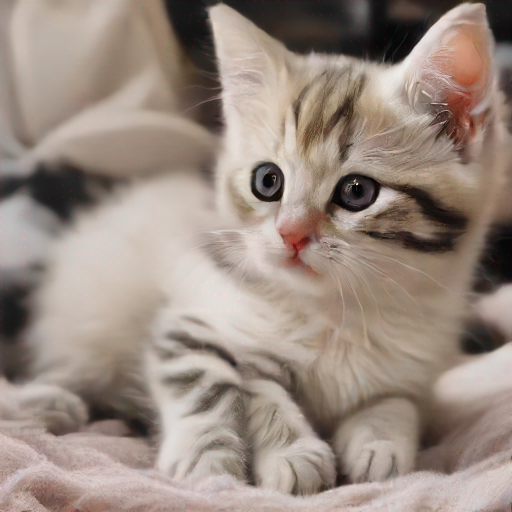

In [6]:
import numpy as np

prompt = "cute cat"
image = text2image_pipe(
    prompt,
    num_inference_steps=1,
    height=512,
    width=512,
    guidance_scale=0.0,
    generator=np.random.RandomState(987),
).images[0]
image.save("cat.png")
image

In [7]:
del text2image_pipe
gc.collect();

## Image-to-Image generation
[back to top ⬆️](#Table-of-contents:)


Image-to-image generation lets you transform images to match the characteristics provided in the text description. We can reuse the already converted model for running the Image2Image generation pipeline. For that, we should replace `OVStableDiffusionXLPipeline` with `OVStableDiffusionXLImage2ImagePipeline`.

In [8]:
from optimum.intel import OVStableDiffusionXLImg2ImgPipeline

image2image_pipe = OVStableDiffusionXLImg2ImgPipeline.from_pretrained(model_dir, device=device.value)

Compiling the vae_decoder to AUTO ...
Compiling the unet to AUTO ...
Compiling the text_encoder to AUTO ...
Compiling the text_encoder_2 to AUTO ...
Compiling the vae_encoder to AUTO ...


In [9]:
photo_prompt = "a cute cat with bow tie"

`strength` parameter is important for the image-to-image generation pipeline. It is a value between 0.0 and 1.0, that controls the amount of noise that is added to the input image. Values that approach 1.0 enable lots of variations but will also produce images that are not semantically consistent with the input, then close to 0, less noise will be added and the target image will preserve source image content. strength has an impact not only on a number of noise but also the number of generation steps. The number of denoising iterations in the image-to-image generation pipeline is calculated as `int(num_inference_steps * strength)`. With sdxl-turbo we should be careful with selecting `num_inference_steps` and `strength` to produce the correct result and make sure that the number of steps used in pipeline >= 1 after applying strength multiplication. e.g. in example below, we will use `num_inference_steps=2` and `stength=0.5`, finally, we get 0.5 * 2.0 = 1 step in our pipeline.

  0%|          | 0/1 [00:00<?, ?it/s]

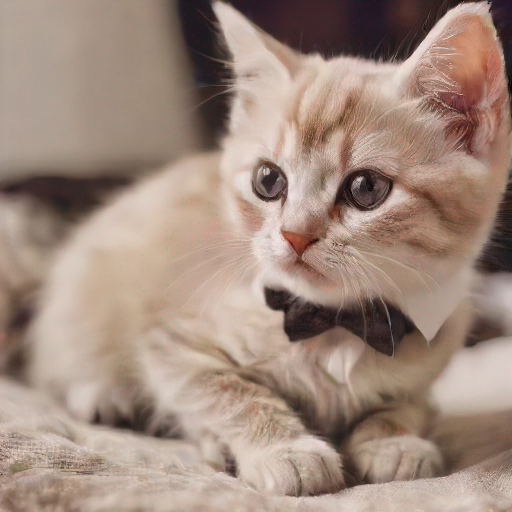

In [10]:
photo_image = image2image_pipe(
    photo_prompt,
    image=image,
    num_inference_steps=2,
    generator=np.random.RandomState(511),
    guidance_scale=0.0,
    strength=0.5,
).images[0]
photo_image.save("cat_tie.png")
photo_image

In [11]:
del image2image_pipe
gc.collect();

## Quantization
[back to top ⬆️](#Table-of-contents:)


[NNCF](https://github.com/openvinotoolkit/nncf/) enables post-training quantization by adding quantization layers into model graph and then using a subset of the training dataset to initialize the parameters of these additional quantization layers. Quantized operations are executed in `INT8` instead of `FP32`/`FP16` making model inference faster.

According to `SDXL-Turbo Model` structure, the UNet model takes up significant portion of the overall pipeline execution time. Now we will show you how to optimize the UNet part using [NNCF](https://github.com/openvinotoolkit/nncf/) to reduce computation cost and speed up the pipeline. Quantizing the rest of the SDXL pipeline does not significantly improve inference performance but can lead to a substantial degradation of accuracy.

The optimization process contains the following steps:

1. Create a calibration dataset for quantization.
2. Run `nncf.quantize()` to obtain quantized model.
3. Save the `INT8` model using `openvino.save_model()` function.

Please select below whether you would like to run quantization to improve model inference speed.

In [12]:
skip_for_device = "GPU" in device.value
to_quantize = widgets.Checkbox(value=not skip_for_device, description="Quantization", disabled=skip_for_device)
to_quantize

Checkbox(value=True, description='Quantization')

In [13]:
# Fetch `skip_kernel_extension` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
)
open("skip_kernel_extension.py", "w").write(r.text)

int8_pipe = None

%load_ext skip_kernel_extension

### Prepare calibration dataset
[back to top ⬆️](#Table-of-contents:)


We use a portion of [conceptual_captions](https://huggingface.co/datasets/conceptual_captions) dataset from Hugging Face as calibration data.
To collect intermediate model inputs for calibration we should customize `CompiledModel`.

In [14]:
UNET_INT8_OV_PATH = model_dir / "optimized_unet" / "openvino_model.xml"


def disable_progress_bar(pipeline, disable=True):
    if not hasattr(pipeline, "_progress_bar_config"):
        pipeline._progress_bar_config = {"disable": disable}
    else:
        pipeline._progress_bar_config["disable"] = disable

In [15]:
%%skip not $to_quantize.value

import datasets
import numpy as np
from tqdm.notebook import tqdm
from transformers import set_seed
from typing import Any, Dict, List

set_seed(1)

class CompiledModelDecorator(ov.CompiledModel):
    def __init__(self, compiled_model: ov.CompiledModel, data_cache: List[Any] = None):
        super().__init__(compiled_model)
        self.data_cache = data_cache if data_cache else []

    def __call__(self, *args, **kwargs):
        self.data_cache.append(*args)
        return super().__call__(*args, **kwargs)

def collect_calibration_data(pipe, subset_size: int) -> List[Dict]:
    original_unet = pipe.unet.request
    pipe.unet.request = CompiledModelDecorator(original_unet)

    dataset = datasets.load_dataset("google-research-datasets/conceptual_captions", split="train", trust_remote_code=True).shuffle(seed=42)
    disable_progress_bar(pipe)

    # Run inference for data collection
    pbar = tqdm(total=subset_size)
    diff = 0
    for batch in dataset:
        prompt = batch["caption"]
        if len(prompt) > pipe.tokenizer.model_max_length:
            continue
        _ = pipe(
            prompt,
            num_inference_steps=1,
            height=512,
            width=512,
            guidance_scale=0.0,
            generator=np.random.RandomState(987)
        )
        collected_subset_size = len(pipe.unet.request.data_cache)
        if collected_subset_size >= subset_size:
            pbar.update(subset_size - pbar.n)
            break
        pbar.update(collected_subset_size - diff)
        diff = collected_subset_size

    calibration_dataset = pipe.unet.request.data_cache
    disable_progress_bar(pipe, disable=False)
    pipe.unet.request = original_unet
    return calibration_dataset

In [16]:
%%skip not $to_quantize.value

if not UNET_INT8_OV_PATH.exists():
    text2image_pipe = OVStableDiffusionXLPipeline.from_pretrained(model_dir, device=device.value)
    unet_calibration_data = collect_calibration_data(text2image_pipe, subset_size=200)

Compiling the vae_decoder to AUTO ...
Compiling the unet to AUTO ...
Compiling the text_encoder to AUTO ...
Compiling the text_encoder_2 to AUTO ...
Compiling the vae_encoder to AUTO ...


  0%|          | 0/200 [00:00<?, ?it/s]

### Run quantization
[back to top ⬆️](#Table-of-contents:)


Create a quantized model from the pre-trained converted OpenVINO model. Quantization of the first and last `Convolution` layers impacts the generation results. We recommend using `IgnoredScope` to keep accuracy sensitive `Convolution` layers in FP16 precision.

> **NOTE**: Quantization is time and memory consuming operation. Running quantization code below may take some time.

In [17]:
%%skip not $to_quantize.value

import nncf
from nncf.scopes import IgnoredScope

UNET_OV_PATH = model_dir / "unet" / "openvino_model.xml"
if not UNET_INT8_OV_PATH.exists():
    unet = core.read_model(UNET_OV_PATH)
    quantized_unet = nncf.quantize(
        model=unet,
        model_type=nncf.ModelType.TRANSFORMER,
        calibration_dataset=nncf.Dataset(unet_calibration_data),
        ignored_scope=IgnoredScope(
            names=[
                "__module.model.conv_in/aten::_convolution/Convolution",
                "__module.model.up_blocks.2.resnets.2.conv_shortcut/aten::_convolution/Convolution",
                "__module.model.conv_out/aten::_convolution/Convolution"
            ],
        ),
    )
    ov.save_model(quantized_unet, UNET_INT8_OV_PATH)

Output()

Output()

INFO:nncf:3 ignored nodes were found by names in the NNCFGraph
INFO:nncf:Not adding activation input quantizer for operation: 6 __module.model.conv_in/aten::_convolution/Convolution
14 __module.model.conv_in/aten::_convolution/Add

INFO:nncf:Not adding activation input quantizer for operation: 317 __module.model.up_blocks.2.resnets.2.conv_shortcut/aten::_convolution/Convolution
543 __module.model.up_blocks.2.resnets.2.conv_shortcut/aten::_convolution/Add

INFO:nncf:Not adding activation input quantizer for operation: 1242 __module.model.conv_out/aten::_convolution/Convolution
1426 __module.model.conv_out/aten::_convolution/Add



Output()

Output()

Let us check predictions with the quantized UNet using the same input data.

Compiling the text_encoder to AUTO ...
Compiling the text_encoder_2 to AUTO ...


  0%|          | 0/1 [00:00<?, ?it/s]

Compiling the unet to AUTO ...
Compiling the vae_decoder to AUTO ...


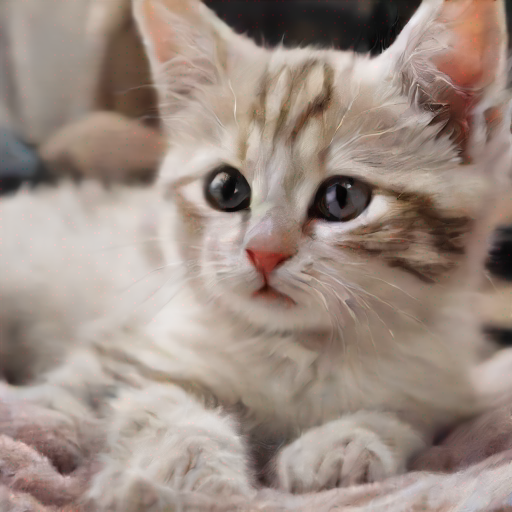

In [18]:
%%skip not $to_quantize.value

from IPython.display import display

int8_text2image_pipe = OVStableDiffusionXLPipeline.from_pretrained(model_dir, device=device.value, compile=False)
int8_text2image_pipe.unet.model = core.read_model(UNET_INT8_OV_PATH)
int8_text2image_pipe.unet.request = None

prompt = "cute cat"
image = int8_text2image_pipe(prompt, num_inference_steps=1, height=512, width=512, guidance_scale=0.0, generator=np.random.RandomState(987)).images[0]
display(image)

Compiling the text_encoder to AUTO ...
Compiling the text_encoder_2 to AUTO ...
Compiling the vae_encoder to AUTO ...


  0%|          | 0/1 [00:00<?, ?it/s]

Compiling the unet to AUTO ...
Compiling the vae_decoder to AUTO ...


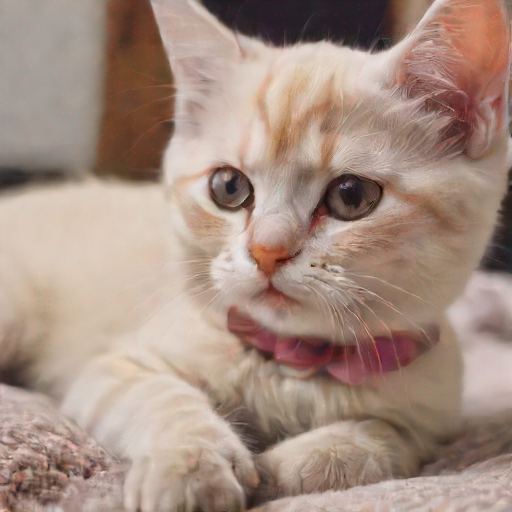

In [19]:
%%skip not $to_quantize.value

int8_image2image_pipe = OVStableDiffusionXLImg2ImgPipeline.from_pretrained(model_dir, device=device.value, compile=False)
int8_image2image_pipe.unet.model = core.read_model(UNET_INT8_OV_PATH)
int8_image2image_pipe.unet.request = None

photo_prompt = "a cute cat with bow tie"
photo_image = int8_image2image_pipe(photo_prompt, image=image, num_inference_steps=2, generator=np.random.RandomState(511), guidance_scale=0.0, strength=0.5).images[0]
display(photo_image)

#### Compare UNet file size
[back to top ⬆️](#Table-of-contents:)


In [20]:
%%skip not $to_quantize.value

fp16_ir_model_size = UNET_OV_PATH.with_suffix(".bin").stat().st_size / 1024
quantized_model_size = UNET_INT8_OV_PATH.with_suffix(".bin").stat().st_size / 1024

print(f"FP16 model size: {fp16_ir_model_size:.2f} KB")
print(f"INT8 model size: {quantized_model_size:.2f} KB")
print(f"Model compression rate: {fp16_ir_model_size / quantized_model_size:.3f}")

FP16 model size: 5014578.62 KB
INT8 model size: 2517944.84 KB
Model compression rate: 1.992


### Compare inference time of the FP16 and INT8 models
[back to top ⬆️](#Table-of-contents:)


To measure the inference performance of the `FP16` and `INT8` pipelines, we use median inference time on calibration subset.

> **NOTE**: For the most accurate performance estimation, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications.

In [21]:
%%skip not $to_quantize.value

import time

validation_size = 7
calibration_dataset = datasets.load_dataset("google-research-datasets/conceptual_captions", split="train", trust_remote_code=True)
validation_data = []
for batch in calibration_dataset:
    prompt = batch["caption"]
    validation_data.append(prompt)

def calculate_inference_time(pipe, dataset):
    inference_time = []
    disable_progress_bar(pipe)

    for idx, prompt in enumerate(dataset):
        start = time.perf_counter()
        image = pipe(
            prompt,
            num_inference_steps=1,
            guidance_scale=0.0,
            generator=np.random.RandomState(23)
        ).images[0]
        end = time.perf_counter()
        delta = end - start
        inference_time.append(delta)
        if idx >= validation_size:
            break
    disable_progress_bar(pipe, disable=False)
    return np.median(inference_time)

In [22]:
%%skip not $to_quantize.value

int8_latency = calculate_inference_time(int8_text2image_pipe, validation_data)
text2image_pipe = OVStableDiffusionXLPipeline.from_pretrained(model_dir, device=device.value)
fp_latency = calculate_inference_time(text2image_pipe, validation_data)
print(f"FP16 pipeline latency: {fp_latency:.3f}")
print(f"INT8 pipeline latency: {int8_latency:.3f}")
print(f"Text-to-Image generation speed up: {fp_latency / int8_latency:.3f}")

Compiling the vae_decoder to AUTO ...
Compiling the unet to AUTO ...
Compiling the text_encoder_2 to AUTO ...
Compiling the text_encoder to AUTO ...
Compiling the vae_encoder to AUTO ...


FP16 pipeline latency: 1.804
INT8 pipeline latency: 0.715
Text-to-Image generation speed up: 2.524


## Interactive Demo
[back to top ⬆️](#Table-of-contents:)


Now, you can check model work using own text descriptions. Provide text prompt in the text box and launch generation using Run button. Additionally you can control generation with additional parameters:
* Seed - random seed for initialization
* Steps - number of generation steps
* Height and Width - size of generated image

> Please note that increasing image size may require to increasing number of steps for accurate result. We recommend running 104x1024 resolution image generation using 4 steps.

Please select below whether you would like to use the quantized model to launch the interactive demo.

In [23]:
quantized_model_present = UNET_INT8_OV_PATH.exists()

use_quantized_model = widgets.Checkbox(
    value=True if quantized_model_present else False,
    description="Use quantized model",
    disabled=False,
)

use_quantized_model

Checkbox(value=True, description='Use quantized model')

In [ ]:
import gradio as gr

text2image_pipe = OVStableDiffusionXLPipeline.from_pretrained(model_dir, device=device.value)
if use_quantized_model.value:
    if not quantized_model_present:
        raise RuntimeError("Quantized model not found.")
    text2image_pipe.unet.model = core.read_model(UNET_INT8_OV_PATH)
    text2image_pipe.unet.request = core.compile_model(text2image_pipe.unet.model, device.value)


def generate_from_text(text, seed, num_steps, height, width):
    result = text2image_pipe(
        text,
        num_inference_steps=num_steps,
        guidance_scale=0.0,
        generator=np.random.RandomState(seed),
        height=height,
        width=width,
    ).images[0]
    return result


with gr.Blocks() as demo:
    with gr.Column():
        positive_input = gr.Textbox(label="Text prompt")
        with gr.Row():
            seed_input = gr.Number(precision=0, label="Seed", value=42, minimum=0)
            steps_input = gr.Slider(label="Steps", value=1, minimum=1, maximum=4, step=1)
            height_input = gr.Slider(label="Height", value=512, minimum=256, maximum=1024, step=32)
            width_input = gr.Slider(label="Width", value=512, minimum=256, maximum=1024, step=32)
            btn = gr.Button()
        out = gr.Image(
            label=("Result (Quantized)" if use_quantized_model.value else "Result (Original)"),
            type="pil",
            width=512,
        )
        btn.click(
            generate_from_text,
            [positive_input, seed_input, steps_input, height_input, width_input],
            out,
        )
        gr.Examples(
            [
                ["cute cat", 999],
                [
                    "underwater world coral reef, colorful jellyfish, 35mm, cinematic lighting, shallow depth of field,  ultra quality, masterpiece, realistic",
                    89,
                ],
                [
                    "a photo realistic happy white poodle dog ​​playing in the grass, extremely detailed, high res, 8k, masterpiece, dynamic angle",
                    1569,
                ],
                [
                    "Astronaut on Mars watching sunset, best quality, cinematic effects,",
                    65245,
                ],
                [
                    "Black and white street photography of a rainy night in New York, reflections on wet pavement",
                    48199,
                ],
            ],
            [positive_input, seed_input],
        )

# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/
# if you want create public link for sharing demo, please add share=True
try:
    demo.launch(debug=True)
except Exception:
    demo.launch(share=True, debug=True)